In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.tree import plot_tree

#### Dataset Creation

In [2]:
# Seed for reproducibility
random.seed(42)

# Creating the dataset
data = {
    'Delivery Distance (km)': [random.randint(5, 50) for _ in range(30)],
    'Vehicle Type': [random.choice(['Truck', 'Van', 'TRK', 'van']) for _ in range(30)],
    'Weather Conditions': [random.choice(['Clear', 'Rain', 'Snow', 'Fog']) for _ in range(30)],
    'Delivery Time (hours)': [round(random.uniform(1, 6), 1) for _ in range(30)],
    'Delayed (Yes/No)': [random.choice(['Yes', 'No']) for _ in range(30)]
}

data = pd.DataFrame(data)

# Introduce missing values in 'Weather Conditions' column
missing_indices = random.sample(range(30), 5)  # Randomly pick 5 rows to be missing
data.loc[missing_indices, 'Weather Conditions'] = np.nan

# Introduce outliers in 'Delivery Distance (km)' column
outlier_indices = random.sample(range(30), 3)  # Randomly pick 3 rows for outliers
for idx in outlier_indices:
    data.loc[idx, 'Delivery Distance (km)'] = random.randint(60, 100)  # Extreme values (e.g., > 50 km)

# Introduce inconsistent entries in 'Vehicle Type' column
inconsistent_indices = random.sample(range(30), 4)  # Randomly pick 4 rows to have inconsistent vehicle type
for idx in inconsistent_indices:
    data.loc[idx, 'Vehicle Type'] = data.loc[idx, 'Vehicle Type'].lower()  # Change to lowercase

print("\nData with Missing Values, Outliers, and Inconsistent Entries:")
data.head()


Data with Missing Values, Outliers, and Inconsistent Entries:


,Delivery Distance (km),Vehicle Type,Weather Conditions,Delivery Time (hours),Delayed (Yes/No)
0,45,TRK,Clear,3.0,No
1,12,Truck,Fog,5.6,Yes
2,6,Van,Snow,3.3,No
3,22,van,Fog,2.3,No
4,20,TRK,NaN,2.2,Yes


#### Data Cleaning

In [3]:
missing_values = data.isnull().sum()
print(missing_values)

Delivery Distance (km)    0
Vehicle Type              0
Weather Conditions        5
Delivery Time (hours)     0
Delayed (Yes/No)          0
dtype: int64


In [4]:
# Step 1: Handle Missing Values
mode_weather = data['Weather Conditions'].mode()[0]
data['Weather Conditions'].fillna(mode_weather)

# Step 2: Address Outliers
Q1 = data['Delivery Distance (km)'].quantile(0.25)
Q3 = data['Delivery Distance (km)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['Delivery Distance (km)'] = data['Delivery Distance (km)'].clip(lower=lower_bound, upper=upper_bound)

# Step 3: Resolve Inconsistencies in Categorical Features
data['Vehicle Type'] = data['Vehicle Type'].str.lower()
data['Vehicle Type'] = data['Vehicle Type'].replace({'truck': 'Truck', 'van': 'Van', 'trk': 'Truck'})

# Display the cleaned dataset
print("\nFinal Cleaned Dataset:")
print(data.head())


Final Cleaned Dataset:
   Delivery Distance (km) Vehicle Type Weather Conditions  \
0                    45.0        Truck              Clear   
1                    12.0        Truck                Fog   
2                     6.0          Van               Snow   
3                    22.0          Van                Fog   
4                    20.0        Truck                NaN   

   Delivery Time (hours) Delayed (Yes/No)  
0                    3.0               No  
1                    5.6              Yes  
2                    3.3               No  
3                    2.3               No  
4                    2.2              Yes  


- Weather Conditions is a categorical variable. The mode represents the most typical weather condition and prevents introducing new or unrealistic categories.  

- IQR is robust to outliers and captures the central 50% of data. Outliers are capped (clipped) at the lower and upper bounds to retain data integrity without complete removal.

- Normalize the text to lowercase to ensure uniformity. Map all variations of a category (e.g., "trk" → "Truck") to a consistent label.

#### Analysis and Optimization

In [5]:
# Prepare data
X = data.drop(columns=['Delayed (Yes/No)'])  # Features
y = data['Delayed (Yes/No)']  # Target

# Encode categorical variables
label_encoders = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode target variable
y = LabelEncoder().fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree Model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Model Evaluation
tree_preds = tree_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

tree_acc = accuracy_score(y_test, tree_preds)
rf_acc = accuracy_score(y_test, rf_preds)

print(f"Decision Tree Accuracy: {tree_acc:.2f}")
print(f"Random Forest Accuracy: {rf_acc:.2f}")

print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, tree_preds))
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_preds))

Decision Tree Accuracy: 0.78
Random Forest Accuracy: 0.89

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.71      0.83         7

    accuracy                           0.78         9
   macro avg       0.75      0.86      0.75         9
weighted avg       0.89      0.78      0.80         9


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.86      0.92         7

    accuracy                           0.89         9
   macro avg       0.83      0.93      0.86         9
weighted avg       0.93      0.89      0.90         9



In [6]:
processed_summary = {
    "X_train Shape": X_train.shape,
    "X_test Shape": X_test.shape,
    "y_train Shape (Regression)": y_train.shape,
    "y_test Shape (Regression)": y_test.shape,
}

processed_summary

{'X_train Shape': (21, 4),
 'X_test Shape': (9, 4),
 'y_train Shape (Regression)': (21,),
 'y_test Shape (Regression)': (9,)}

Why choose Random Forest Model?  
- Random Forest handles non-linear relationships and categorical variables effectively.

Why choose Decision Tree Model?
- Captures non-linear relationships and is interpretable.

/var/folders/c2/snb3yrcs1w38z7qd3r208vch0000gn/T/ipykernel_97171/2706311865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')


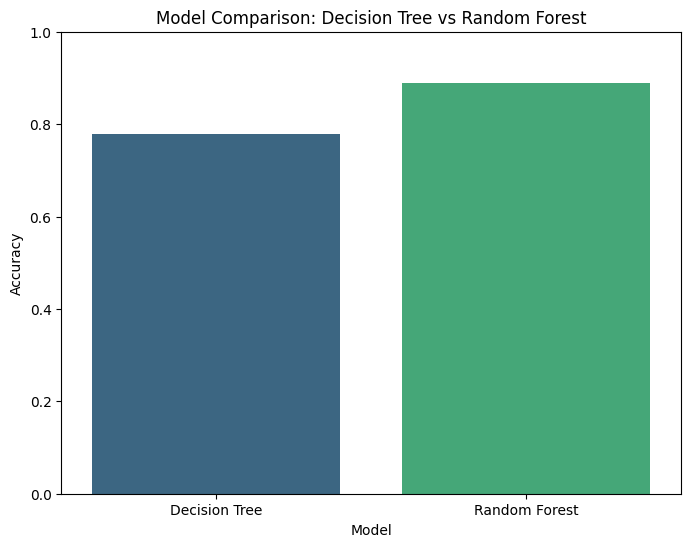

In [7]:
# Prepare accuracy data
accuracy_data = {
    'Model': ['Decision Tree', 'Random Forest'],
    'Accuracy': [tree_acc, rf_acc]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')
plt.title('Model Comparison: Decision Tree vs Random Forest')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()

According to the plot, we can see that random forest model is better than decision tree because of its accuracy.

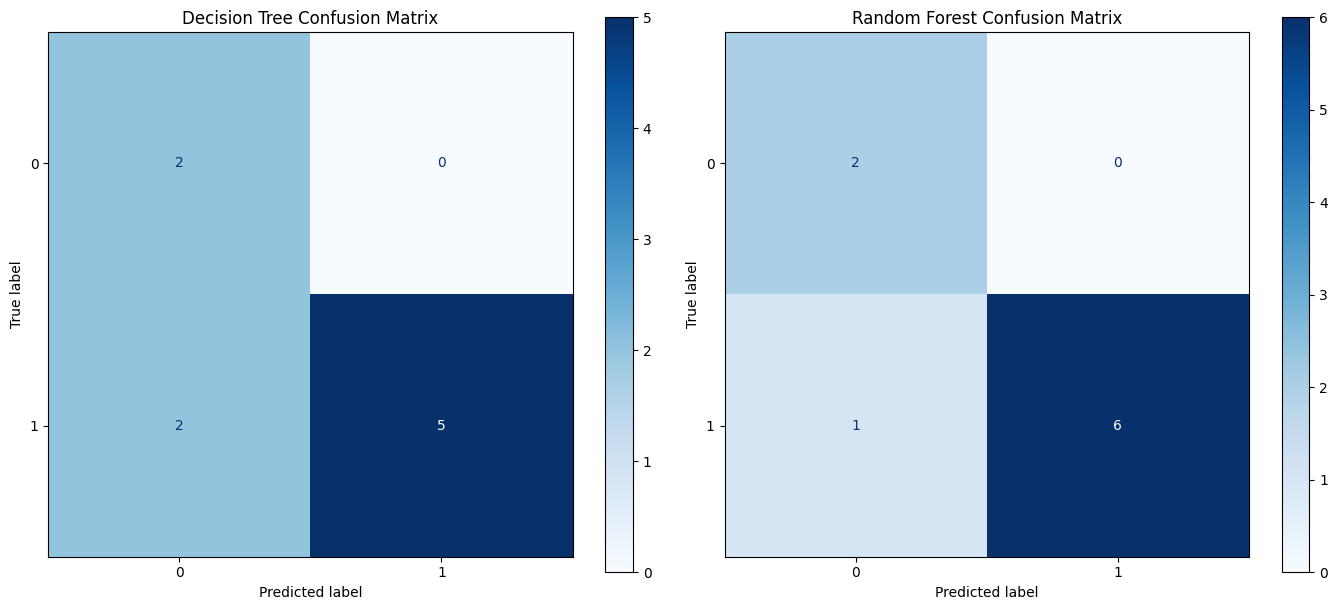

In [8]:
# Encode target variable and store in label_encoders
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)
label_encoders['Delayed (Yes/No)'] = target_encoder

# Decision Tree Confusion Matrix
tree_cm = confusion_matrix(y_test, tree_preds)
# Random Forest Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_preds)

# Plotting Decision Tree Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay(tree_cm, display_labels=target_encoder.classes_).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Decision Tree Confusion Matrix')

# Plotting Random Forest Confusion Matrix
ConfusionMatrixDisplay(rf_cm, display_labels=target_encoder.classes_).plot(ax=ax[1], cmap='Blues')
ax[1].set_title('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

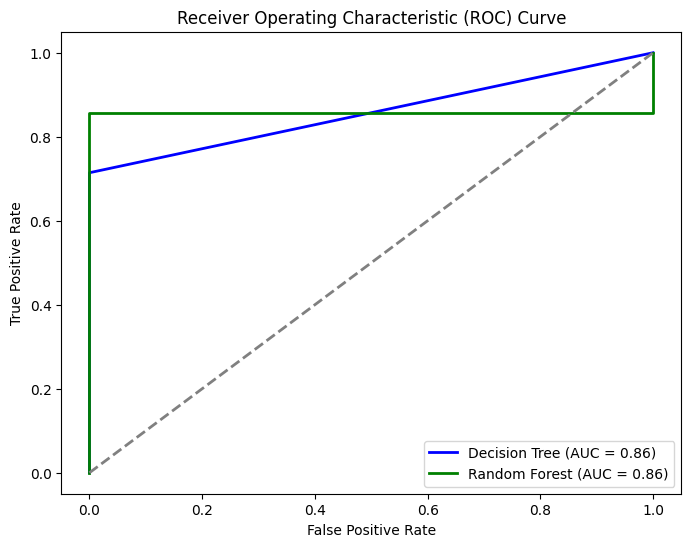

In [9]:
# Get probabilities for ROC curve
tree_probs = tree_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
rf_probs = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Compute ROC curve and AUC for Decision Tree
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_probs)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

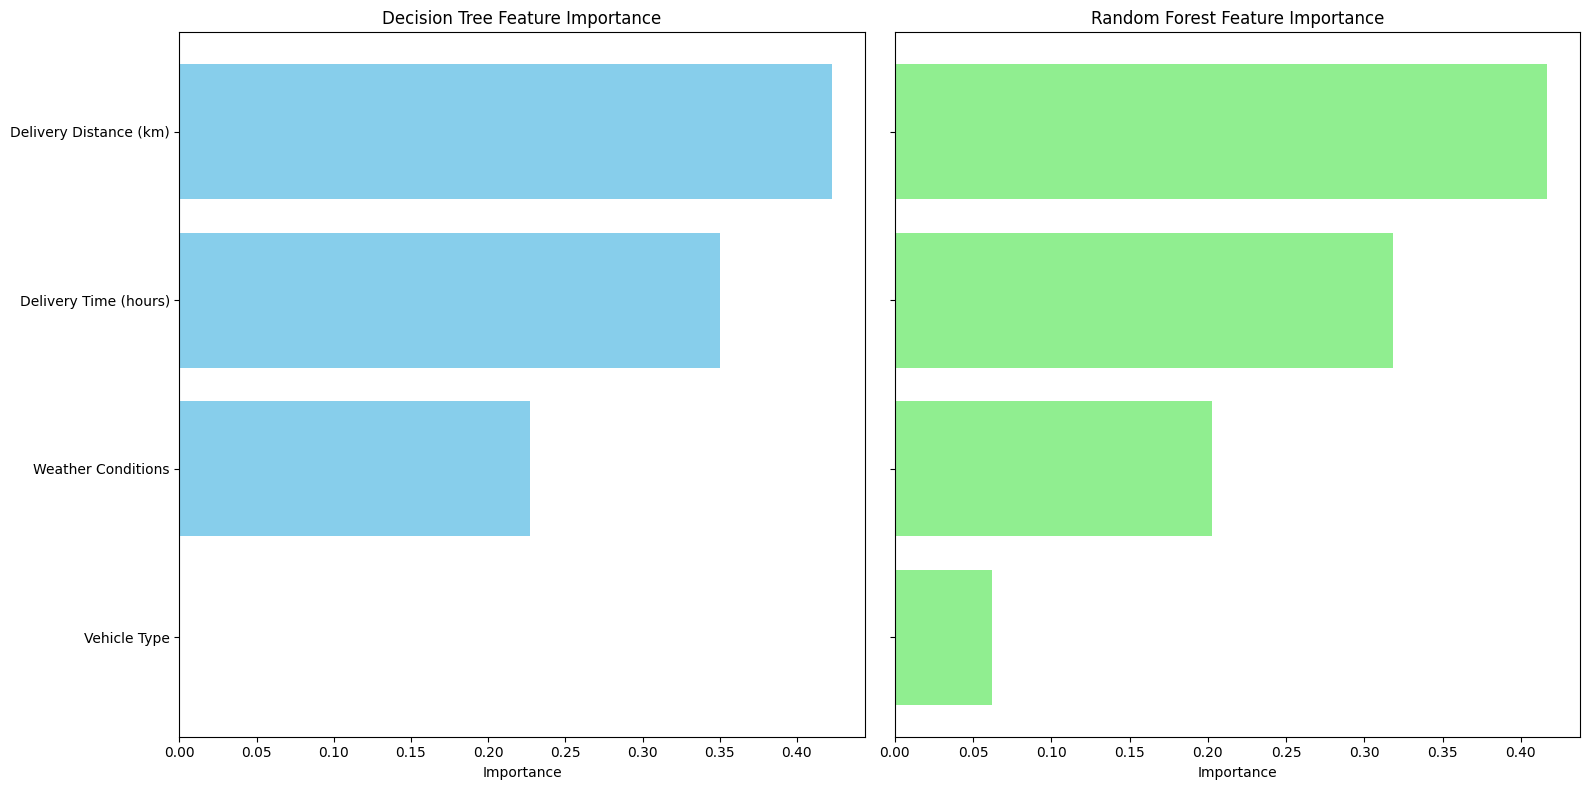


Top Influential Factors from Decision Tree:
Feature: Delivery Distance (km), Importance: 0.4227
Feature: Delivery Time (hours), Importance: 0.3500
Feature: Weather Conditions, Importance: 0.2273
Feature: Vehicle Type, Importance: 0.0000

Top Influential Factors from Random Forest:
Feature: Delivery Distance (km), Importance: 0.4170
Feature: Delivery Time (hours), Importance: 0.3182
Feature: Weather Conditions, Importance: 0.2025
Feature: Vehicle Type, Importance: 0.0623


In [10]:
# Decision Tree Feature Importances
dt_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tree_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Random Forest Feature Importances
rf_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot Decision Tree Feature Importances
axes[0].barh(dt_feature_importances['Feature'], dt_feature_importances['Importance'], color='skyblue')
axes[0].set_title("Decision Tree Feature Importance")
axes[0].set_xlabel("Importance")
axes[0].invert_yaxis()  # Most important feature on top

# Plot Random Forest Feature Importances
axes[1].barh(rf_feature_importances['Feature'], rf_feature_importances['Importance'], color='lightgreen')
axes[1].set_title("Random Forest Feature Importance")
axes[1].set_xlabel("Importance")

# Adjust layout and display
plt.tight_layout()
plt.show()

# Display top influential factors
sorted_features = np.argsort(tree_model.feature_importances_)[::-1]
print("\nTop Influential Factors from Decision Tree:")
for idx in sorted_features:
    print(f"Feature: {X.columns[idx]}, Importance: {tree_model.feature_importances_[idx]:.4f}")

sorted_features = np.argsort(rf_model.feature_importances_)[::-1]
print("\nTop Influential Factors from Random Forest:")
for idx in sorted_features:
    print(f"Feature: {X.columns[idx]}, Importance: {rf_model.feature_importances_[idx]:.4f}")

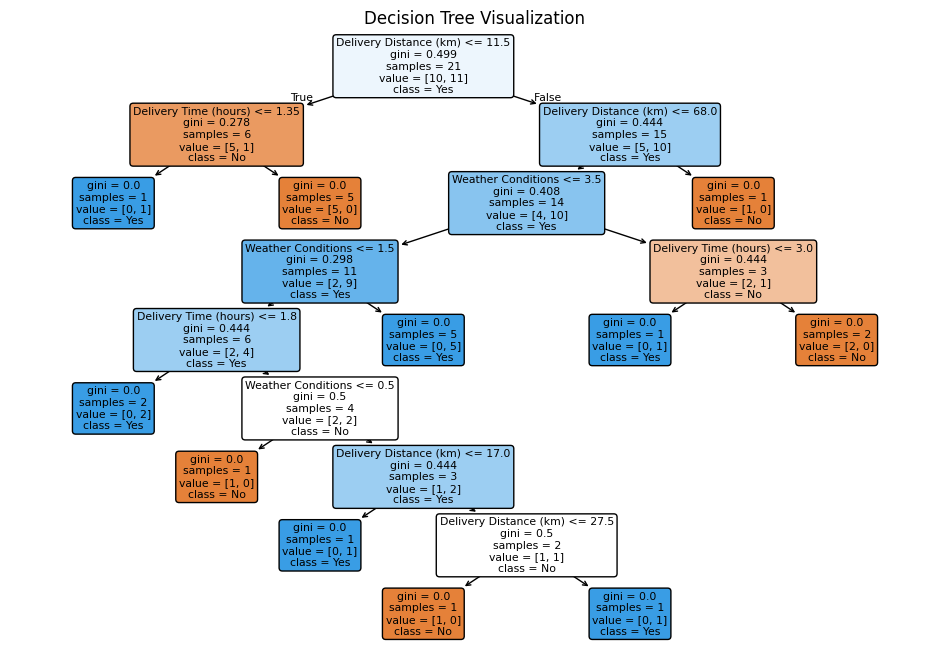

In [11]:
# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(tree_model, feature_names=X.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

#### Observations
- Delivery Distance (km):  
The most influential feature across both models, with importance scores of 0.4227 (Decision Tree) and 0.4170 (Random Forest). Suggests that longer delivery distances are highly correlated with delays.
- Delivery Time (hours):  
The second most influential feature, with scores of 0.3500 (Decision Tree) and 0.3182 (Random Forest). Indicates that deliveries scheduled during peak hours or for extended durations may face delays.
- Weather Conditions:  
The third most influential feature, with scores of 0.2273 (Decision Tree) and 0.2025 (Random Forest). Highlights the impact of weather on delivery performance, especially during adverse conditions.
- Vehicle Type:  
Negligible impact in the Decision Tree (0.0000) but slightly more relevant in the Random Forest (0.0623). Implies that vehicle type is not a critical factor but may contribute marginally in specific scenarios.

#### Route Optimization
To optimize delivery routes, leverage route-planning algorithms like Dijkstra's to minimize distances and apply clustering techniques, such as K-Means, to assign deliveries to nearby drivers efficiently. Analyze delivery time trends to identify peak delay periods and implement dynamic scheduling to avoid congested time slots while optimizing workforce allocation. Incorporate real-time weather data into scheduling to proactively address potential delays and equip vehicles with weather-appropriate tools, such as snow tires, to maintain timely deliveries under adverse conditions. Although vehicle type has low importance, standardizing fleets for specific routes can enhance consistency and overall efficiency.